In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from cwgp.cwgp import CWGP
from cwgp.kernel import RBF
import GPy
import numpy as np

In [2]:
def mean_func(x,df,window_size=3):
#     out = 1/(1+np.exp(x))
#     out = ph.rolling(window=window_size,min_periods=1).mean()
    return 0

In [3]:
CSV_FIlE = "japan3.csv"
df = pd.read_csv(CSV_FIlE)
age = 90
df_all = {}
df_all[age]= df[(df["age"]==age)]

In [4]:
mf = GPy.core.Mapping(1,1)
mf.f = lambda x: mean_func(x,df_all[age])
mf.update_gradients = lambda a,b: None

In [5]:
rate = df_all[age]["rate"].to_numpy().reshape(-1,1)
year = df_all[age]["year"].to_numpy().reshape(-1,1)

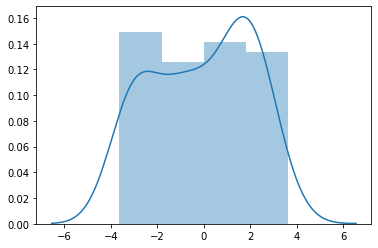

In [6]:
t_1 = CWGP("sal",n=1)
p_1 = t_1.fit(rate).x
x_1, d = t_1.phi.comp_phi(p_1,rate)
sns.distplot(x_1)

 /home/chen/work/venv/lib/python3.6/site-packages/autograd/tracer.py:48: RuntimeWarning:divide by zero encountered in log
 /home/chen/work/venv/lib/python3.6/site-packages/scipy/optimize/_numdiff.py:497: RuntimeWarning:invalid value encountered in subtract
 /home/chen/work/venv/lib/python3.6/site-packages/numpy/linalg/linalg.py:2116: RuntimeWarning:invalid value encountered in det
 /home/chen/work/venv/lib/python3.6/site-packages/scipy/optimize/_numdiff.py:390: RuntimeWarning:invalid value encountered in less
 /home/chen/work/venv/lib/python3.6/site-packages/scipy/optimize/_numdiff.py:390: RuntimeWarning:invalid value encountered in greater
 /home/chen/work/venv/lib/python3.6/site-packages/scipy/optimize/_numdiff.py:405: RuntimeWarning:invalid value encountered in greater_equal


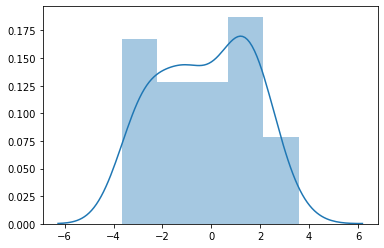

In [7]:
t_2 = CWGP("sal",n=3)
p_2 = t_2.fit(x_1).x
x_2, d = t_2.phi.comp_phi(p_2,x_1)
sns.distplot(x_2)

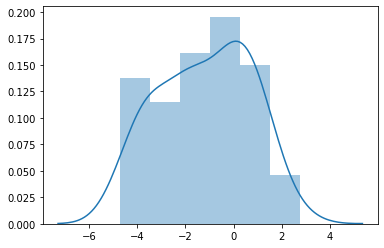

In [8]:
t_3 = CWGP("box_cox",n=1)
p_3 = t_3.fit(x_2).x
x_3, d = t_3.phi.comp_phi(p_3,x_2)
sns.distplot(x_3)


Name : GP regression
Objective : 47.1474964546551
Number of Parameters : 3
Number of Optimization Parameters : 3
Updates : True
Parameters:
  GP_regression.           |                value  |  constraints  |  priors
  Mat32.variance           |   24.150722178649715  |      +ve      |        
  Mat32.lengthscale        |   129.74824550934943  |      +ve      |        
  Gaussian_noise.variance  |  0.18696796874783106  |      +ve      |        


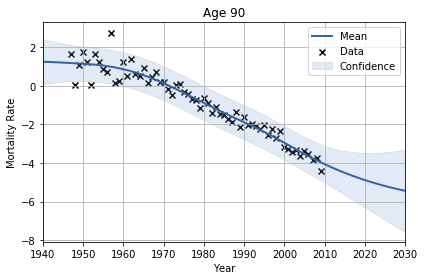

In [9]:
kernel = GPy.kern.Matern32(1)

ratio = 0.9
length = len(df_all[age])
train = int(ratio*length)
train_up, train_low = train, train-train


model_cwgp = GPy.models.GPRegression(df_all[age].year[:, None][train_low:train_up], x_3[train_low:train_up], mean_function=mf, kernel=kernel)
model_cwgp.optimize()
print(model_cwgp)
model_cwgp.plot(plot_limits=[1940,2030])

plt.title('Age ' + str(age))
plt.xlabel('Year')
plt.ylabel('Mortality Rate')

plt.grid(True)
plt.show()

In [10]:
model_cwgp.log_likelihood()

-47.1474964546551

In [11]:
data = []
start,end = 1940,2031
time_span = end-start
for i in range(start,end):
    data.append(model_cwgp.predict(np.array(i).reshape(1,-1)))
tr_data = np.array(data).reshape(-1,1,2)

In [12]:
CI = 1.96
mean = tr_data[:,:,0]
var_upper = mean + CI*np.sqrt(tr_data[:,:,1])
var_lower = mean - CI*np.sqrt(tr_data[:,:,1])
predict_mean = t_3.phi.inv_comp_phi(p_3,mean)
predict_mean = t_2.phi.inv_comp_phi(p_2,predict_mean)
predict_mean = t_1.phi.inv_comp_phi(p_1,predict_mean)
predict_var_upper = t_3.phi.inv_comp_phi(p_3,var_upper)
predict_var_upper = t_2.phi.inv_comp_phi(p_2,predict_var_upper)
predict_var_upper = t_1.phi.inv_comp_phi(p_1,predict_var_upper)
predict_var_lower = t_3.phi.inv_comp_phi(p_3,var_lower)
predict_var_lower = t_2.phi.inv_comp_phi(p_2,predict_var_lower)
predict_var_lower = t_1.phi.inv_comp_phi(p_1,predict_var_lower)

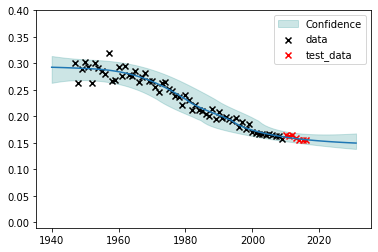

In [13]:
plt.fill_between(np.linspace(start,end,time_span),np.ravel(predict_var_upper),np.ravel(predict_var_lower),color=(0,0.5,0.5,0.2), label="Confidence")
plt.scatter(year[train_low:train_up], rate[train_low:train_up], marker="x", color='black', label="data")
plt.scatter(year[train_up:], rate[train_up:], marker="x", color='red')
plt.scatter(year[:train_low], rate[:train_low], marker="x", color='red', label="test_data")
plt.legend()
plt.ylim([-0.01,0.4])
plt.plot(np.linspace(start,end,time_span),predict_mean, label="mean")

In [14]:
n = 7
rmse = np.sqrt(np.sum((np.ravel(predict_mean[70:77])-df_all[age].rate[train_up:])**2)/n)
mae = np.sum(np.abs(np.ravel(predict_mean[70:77])-df_all[age].rate[train_up:]))/n

rmse,mae

(0.0036593999645834654, 0.002856720647593466)